In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as seaborn
import streamlit as st
import tensorflow as tf
import plotly.graph_objects as go

# Data Manipulation and Preprocessing
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Model Building and Training
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.arima.model import ARIMA

# Model Evaluation and Selection
from sklearn.model_selection import (
    train_test_split, 
    GridSearchCV, 
    RandomizedSearchCV, 
    cross_val_score, 
    learning_curve
)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Hyperparameter Tuning
import optuna

# Pipeline
from sklearn.pipeline import Pipeline, make_pipeline

# Model Saving and Loading
import joblib




In [36]:
data = pd.read_csv('Flat_Type/5_Room_new.csv')
# Set year_month as the index
data.set_index("year_month", inplace=True)

In [37]:
data['mean'] = pd.to_numeric(data['mean'], errors='coerce')
data['high_price'] = pd.to_numeric(data['high_price'], errors='coerce')
data['low_price'] = pd.to_numeric(data['low_price'], errors='coerce')
data['Index'] = pd.to_numeric(data['Index'], errors='coerce')
data['Change'] =  data['Change'].replace({'%': ''}, regex=True).astype(float) / 100
data['prev_close'] = pd.to_numeric(data['prev_close'], errors='coerce')
data['rolling_mean'] = pd.to_numeric(data['rolling_mean'], errors='coerce')

In [38]:
data.isnull().sum()


mean            0
median_price    0
high_price      0
low_price       0
Index           0
Change          3
prev_close      1
rolling_mean    2
dtype: int64

Mean Squared Error: 5895445264.223306
R^2 Score: -0.9008090421296258


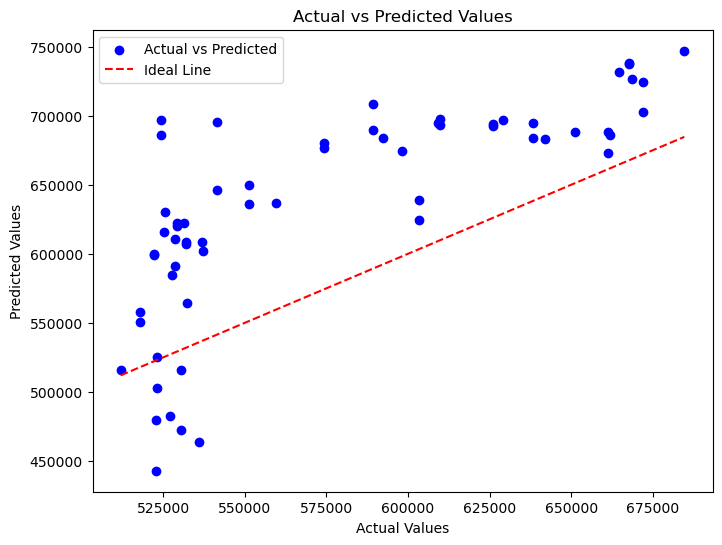

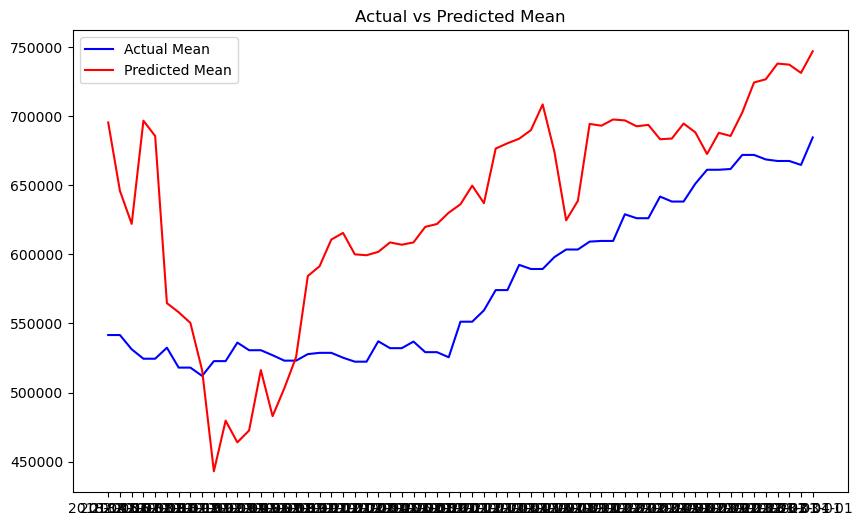

In [48]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Split data into train and test sets (80% train, 20% test)
train_size = int(len(data) * 0.8)
train, test = data[3:train_size], data[train_size + 3:]

# Define features (exclude target columns)
X_train = train.drop(columns=['mean', 'median_price'])
y_train = train['mean']
X_test = test.drop(columns=['mean', 'median_price'])
y_test = test['mean']

# Set up the sliding window approach
window_size = 20 # Define the size of the window (e.g., 12 months)
predictions = []  # List to store predictions

# Loop through the test data to implement the sliding window
for i in range(window_size, len(test)):
    # Create the training set for the current window
    X_train_window = X_train.iloc[i - window_size:i]
    y_train_window = y_train.iloc[i - window_size:i]

    # Train the Linear Regression model on the current window
    model = LinearRegression()
    model.fit(X_train_window, y_train_window)

    # Make prediction for the next data point
    X_test_point = X_test.iloc[i:i+1]
    y_pred_point = model.predict(X_test_point)

    # Append the predicted value to the predictions list
    predictions.append(y_pred_point[0])

# Convert predictions to a numpy array
predictions = np.array(predictions)

# Evaluate the model's performance using MSE and R²
mse = mean_squared_error(y_test[:len(predictions)], predictions)
r2 = r2_score(y_test[:len(predictions)], predictions)

# Print the performance metrics

print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Plotting the actual vs predicted values
plt.figure(figsize=(8, 6))
plt.scatter(y_test[:len(predictions)], predictions, color='blue', label='Actual vs Predicted')
plt.plot([min(y_test[:len(predictions)]), max(y_test[:len(predictions)])],
         [min(y_test[:len(predictions)]), max(y_test[:len(predictions)])], color='red', linestyle='--', label='Ideal Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.show()

# Plot actual vs predicted values over time
plt.figure(figsize=(10, 6))
plt.plot(y_test.index[:len(predictions)], y_test[:len(predictions)], label='Actual Mean', color='blue')
plt.plot(y_test.index[:len(predictions)], predictions, label='Predicted Mean', color='red')
plt.legend()
plt.title('Actual vs Predicted Mean')
plt.show()


In [44]:
data = data[3:]

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error, r2_score

# Normalize the features and target variable (LSTM works better on normalized data)
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Prepare the data for LSTM (create sequences)
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, 1:])  # All columns except the target
        y.append(data[i+seq_length, 1])     # Target column (last one)
    return np.array(X), np.array(y)

# Sequence length (lookback period for prediction)
seq_length = 10  # Number of previous days to predict the next day

# Create the sequences for training
X, y = create_sequences(scaled_data, seq_length)

# Reshape X to be suitable for LSTM [samples, time steps, features]
X = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

# Split the data into training and test sets
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Initialize a list to store the predictions
predictions = []

# Apply Sliding Window approach
for i in range(len(X_test)):
    # Define the current training window (use previous `seq_length` data points)
    X_train_window = X_train[-seq_length:]
    y_train_window = y_train[-seq_length:]
    
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train_window.shape[1], X_train_window.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=50, return_sequences=False))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    
    # Train the model on the current window
    model.fit(X_train_window, y_train_window, epochs=5, batch_size=16, verbose=0)
    
    # Make a prediction for the next time step
    next_pred = model.predict(X_test[i:i+1])
    
    # Inverse scale the prediction
    next_pred_rescaled = scaler.inverse_transform(np.hstack((X_test[i, -1, :], next_pred)))[:, -1]
    
    # Append the prediction to the list
    predictions.append(next_pred_rescaled[0])
    
    # Add the actual value to the training data to slide the window forward
    X_train = np.concatenate((X_train, X_test[i:i+1]), axis=0)
    y_train = np.concatenate((y_train, y_test[i:i+1]), axis=0)

# Evaluate the model's performance using MSE and R²
predictions = np.array(predictions)
mse = mean_squared_error(y_test, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, predictions)

# Print the evaluation metrics
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R² Score: {r2}")

# Plotting the results
plt.figure(figsize=(10,6))
plt.plot(data.index[-len(y_test):], y_test, label='True Values', color='blue')
plt.plot(data.index[-len(y_test):], predictions, label='Predicted Values', color='red', linestyle='--')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Multi-Feature LSTM Time Series Forecasting with Sliding Window')
plt.legend()
plt.show()


c:\Users\firas\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step


ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 1 dimension(s) and the array at index 1 has 2 dimension(s)